# Ciencia de datos de clasificación

Importar librerías

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report,roc_auc_score, roc_curve)
from imblearn.under_sampling import RandomUnderSampler
import mlflow
import mlflow.tensorflow

Importar datos limpios

In [2]:
df=pd.read_csv("listings_limpio.csv")

# Alistamiento de datos

Visualizar dataframe

In [3]:
df.drop(columns=['id'], inplace=True)
df.shape

(17664, 39)

Definir el target

In [4]:
df['Target']= (df['review_scores_rating']>=4.8).astype(int)
df['Target'].value_counts()


Target
0    11341
1     6323
Name: count, dtype: int64

Borrar la variable que se usó para definir el target

In [5]:
cols_review= [c for c in df.columns if "review_scores" in c]
cols_review

['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

In [6]:
df.drop(columns=cols_review, inplace=True)

In [7]:
df.drop(columns='neighbourhood_cleansed',inplace=True)

In [8]:
vars_a_quitar = [
    'bathrooms',
    'bedrooms',
    'TV',
    'Smoke_alarm_home_safety'
    ]
df.drop(columns=vars_a_quitar,inplace=True)

### Ordenar feats

In [9]:
cols_string = df.select_dtypes(include=['object', 'string']).columns.tolist()

In [10]:
cols_bool = df.select_dtypes(include=['bool']).columns.tolist()
df[cols_bool] = df[cols_bool].astype(int)

In [11]:
cols_num = df.select_dtypes(include=['number']).columns.tolist()
cols_num.remove('Target')
cols_bin= [
    c for c in cols_num
    if df[c].dropna().nunique() == 2 and df[c].dropna().isin([0, 1]).all()
]
cols_num=[c for c in cols_num if c not in cols_bin]

In [12]:
feats = cols_num+cols_bin+cols_string
print(len(feats),feats)

27 ['host_response_rate', 'host_acceptance_rate', 'latitude', 'longitude', 'accommodates', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'reviews_per_month', 'Wifi', 'Air_conditioning', 'Kitchen_and_dining', 'Washer_dryer', 'Safe', 'Refrigerator', 'Essentials', 'Services', 'property_Entire_Place', 'property_Hotel_Room', 'property_Other', 'property_Private_Room', 'property_Shared_Room']


In [13]:
df=df[feats+['Target']]
df.head(5)

,host_response_rate,host_acceptance_rate,latitude,longitude,accommodates,beds,price,minimum_nights,maximum_nights,availability_365,...,Safe,Refrigerator,Essentials,Services,property_Entire_Place,property_Hotel_Room,property_Other,property_Private_Room,property_Shared_Room,Target
0,100,100,40.41476,-3.70418,2,2.0,157.0,5,50,342,...,0,0,0,0,1,0,0,0,0,0
1,100,100,40.42247,-3.70577,2,3.0,143.0,5,50,341,...,0,0,0,0,1,0,0,0,0,0
2,100,99,40.41884,-3.69655,4,2.0,65.0,1,30,299,...,0,1,1,0,0,0,0,1,0,0
3,100,100,40.42252,-3.70250,2,1.0,116.0,30,360,305,...,0,1,1,1,1,0,0,0,0,0
4,100,100,40.42252,-3.70250,2,2.0,79.0,30,360,317,...,0,1,1,1,1,0,0,0,0,0


### Separar en train y test

In [14]:
train = df.sample(frac=0.8, random_state=100)
x_train=train.drop(columns=df.columns[-1])
x_train.head()
y_train=train['Target']

In [15]:
test = df.drop(train.index)
x_test=test.drop(columns=df.columns[-1])
x_test.head()
y_test=test['Target']

In [16]:
val = train.sample(frac=0.2, random_state=100)
train = train.drop(val.index)

In [17]:
print(train.shape)
print(val.shape)
print(test.shape)

(11305, 28)
(2826, 28)
(3533, 28)


### Balancear train

In [18]:
rus = RandomUnderSampler(random_state=42)
x_train, y_train = rus.fit_resample(x_train, y_train)
print(y_train.value_counts())
train = pd.concat([x_train, y_train], axis=1) 

Target
0    5071
1    5071
Name: count, dtype: int64


### Procesar variables de entrada

In [19]:
def dataframe_to_dataset(dataframe, shuffle=True):
    dataframe = dataframe.copy()
    labels = dataframe.pop("Target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe), reshuffle_each_iteration=True)
    return ds

In [20]:
batch_size = 32

train_ds = dataframe_to_dataset(train, shuffle=True).batch(batch_size)
val_ds   = dataframe_to_dataset(val, shuffle=False).batch(batch_size)
test_ds  = dataframe_to_dataset(test, shuffle=False).batch(batch_size)

In [21]:
def encode_numerical_feature(feature, name, dataset):
    normalizer = keras.layers.Normalization()
    feat_ds = dataset.map(lambda x, y: x[name])
    feat_ds = feat_ds.map(lambda x: tf.expand_dims(x, -1))
    normalizer.adapt(feat_ds)
    return normalizer(feature)

def encode_categorical_feature(feature, name, dataset, is_string=False):
    lookup_class = keras.layers.StringLookup if is_string else keras.layers.IntegerLookup
    lookup = lookup_class(output_mode="binary")  
    feat_ds = dataset.map(lambda x, y: x[name])
    feat_ds = feat_ds.map(lambda x: tf.expand_dims(x, -1))
    lookup.adapt(feat_ds)
    return lookup(feature)

In [22]:
inputs = []
for i in cols_num:
  inputs.append(keras.Input(shape=(1,), name=i))

for i in cols_bin:
  inputs.append(keras.Input(shape=(1,), name=i, dtype="int64"))

for i in cols_string:
  inputs.append(keras.Input(shape=(1,), name=i, dtype="string"))

In [23]:
feats_encoded=[]
len_feats=len(feats_encoded)
for i,feat in enumerate(cols_num):
  feats_encoded.append(
      encode_numerical_feature(inputs[len_feats+i], feat, train_ds)
  )

len_feats=len(feats_encoded)

for i,feat in enumerate(cols_bin):
  feats_encoded.append(
      encode_categorical_feature(inputs[len_feats+i], feat, train_ds, False)
  )

len_feats=len(feats_encoded)

for i,feat in enumerate(cols_string):
  feats_encoded.append(
      encode_categorical_feature(inputs[len_feats+i], feat, train_ds, True)
  )

all_feats = keras.layers.concatenate(feats_encoded)
len_feats

27

## Red neuronal de clasificación

### Correr con MLFLow

In [ ]:
# Construir modelo
capa1= keras.layers.Dense(32, activation='relu')(all_feats)
capa2 = keras.layers.Dense(32, activation='relu')(capa1)
capa3 = keras.layers.Dense(32, activation='relu')(capa2)
model_layers = keras.layers.Dense(1, activation='sigmoid')(capa3)
model = keras.Model(inputs, model_layers)

#Definir optimizador y compilar
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.BinaryAccuracy(name='accuracy',threshold=0.4),
        keras.metrics.AUC(name='auc'),
        keras.metrics.Precision(name='precision',thresholds=0.4),
        keras.metrics.Recall(name='recall',thresholds=0.4)
    ]
)

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

#Definir experimento y ruta
mlflow.set_tracking_uri("file:///C:/mlruns_proy2")
mlflow.set_experiment("ACTD - CLASIFICACIÓN")

with mlflow.start_run(run_name="RUN 11"):
    #Definir parámetros
    mlflow.log_params({
        "modelo": "DNN",
        "activacion_ocultas":"TANH",
        "n_capas_oculttas": 3,
        "n_neuronas": 32,
        "learning_rate": 1e-3,
        "epochs_max": 50,
        "var_eliminadas": 'camas, baños, cuartos ',
        'threshold': 0.4
    })

    #Entrenar modelo
    history = model.fit(
        train_ds,
        epochs=50,
        validation_data=val_ds
    )

    #Resultados
    test_results = model.evaluate(test_ds, verbose=0)
    test_loss = test_results[0]
    test_acc  = test_results[1]
    test_auc  = test_results[2]
    test_pre = test_results[3]
    test_rec = test_results[4]

    # Métricas de última época en train/val (del history)
    train_loss_final = history.history["loss"][-1]
    val_loss_final   = history.history["val_loss"][-1]
    train_auc_final  = history.history["auc"][-1]
    val_auc_final    = history.history["val_auc"][-1]

    #Guardar las métricas
    mlflow.log_metrics({
        "train_loss_final": train_loss_final,
        "val_loss_final":   val_loss_final,
        "train_auc_final":  train_auc_final,
        "val_auc_final":    val_auc_final,
        "test_loss":        test_loss,
        "test_accuracy":    test_acc,
        "test_auc":         test_auc,
        "test_precision":   test_pre,
        "test_recall":      test_rec
    })

    #Registrar history
    for epoch in range(len(history.history["loss"])):
        mlflow.log_metric("loss",      history.history["loss"][epoch],      step=epoch)
        mlflow.log_metric("val_loss",  history.history["val_loss"][epoch],  step=epoch)

    #Guardar modelo
    mlflow.tensorflow.log_model(model, "model")

    mlflow.end_run(status='FINISHED')

c:\Users\adri_\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


Epoch 1/50
317/317 [==============================] - 9s 13ms/step - loss: 1.4560 - accuracy: 0.5317 - auc: 0.5604 - precision: 0.5215 - recall: 0.7707 - val_loss: 0.6540 - val_accuracy: 0.4947 - val_auc: 0.6546 - val_precision: 0.4064 - val_recall: 0.8837
Epoch 2/50
317/317 [==============================] - 3s 7ms/step - loss: 0.6437 - accuracy: 0.5863 - auc: 0.6720 - precision: 0.5532 - recall: 0.8977 - val_loss: 0.6335 - val_accuracy: 0.5633 - val_auc: 0.6815 - val_precision: 0.4419 - val_recall: 0.8207
Epoch 3/50
317/317 [==============================] - 3s 8ms/step - loss: 0.6224 - accuracy: 0.6214 - auc: 0.7038 - precision: 0.5802 - recall: 0.8779 - val_loss: 0.6035 - val_accuracy: 0.5701 - val_auc: 0.7231 - val_precision: 0.4493 - val_recall: 0.8739
Epoch 4/50
317/317 [==============================] - 2s 7ms/step - loss: 0.6104 - accuracy: 0.6372 - auc: 0.7169 - precision: 0.5928 - recall: 0.8758 - val_loss: 0.6016 - val_accuracy: 0.5807 - val_auc: 0.7255 - val_precision: 0.4

2025/12/01 22:40:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/01 22:40:24 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\adri_\AppData\Local\Temp\tmphr3vs9xc\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\adri_\AppData\Local\Temp\tmphr3vs9xc\model\data\model\assets
2025/12/01 22:41:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Mejor modelo

Epoch 1/50
317/317 [==============================] - 4s 6ms/step - loss: 0.6679 - accuracy: 0.5922 - auc: 0.6273 - precision: 0.5850 - recall: 0.6344 - val_loss: 0.6646 - val_accuracy: 0.5948 - val_auc: 0.6616 - val_precision: 0.4572 - val_recall: 0.6847
Epoch 2/50
317/317 [==============================] - 1s 4ms/step - loss: 0.6422 - accuracy: 0.6278 - auc: 0.6762 - precision: 0.6309 - recall: 0.6159 - val_loss: 0.6521 - val_accuracy: 0.6108 - val_auc: 0.6851 - val_precision: 0.4714 - val_recall: 0.6906
Epoch 3/50
317/317 [==============================] - 2s 5ms/step - loss: 0.6318 - accuracy: 0.6428 - auc: 0.6925 - precision: 0.6487 - recall: 0.6230 - val_loss: 0.6409 - val_accuracy: 0.6210 - val_auc: 0.7016 - val_precision: 0.4810 - val_recall: 0.6975
Epoch 4/50
317/317 [==============================] - 4s 11ms/step - loss: 0.6214 - accuracy: 0.6476 - auc: 0.7073 - precision: 0.6494 - recall: 0.6417 - val_loss: 0.6147 - val_accuracy: 0.6511 - val_auc: 0.7085 - val_precision: 0.5

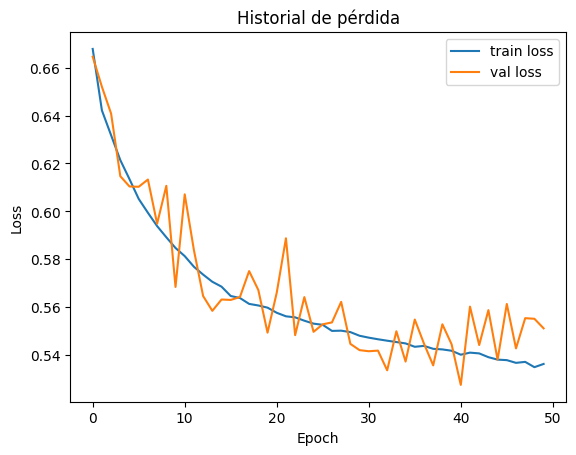

Accuracy : 0.6631757616996765
Precision: 0.5166308879852295
Recall   : 0.7691693305969238
ROC-AUC  : 0.7564818263053894


In [26]:
# Construir modelo
capa1= keras.layers.Dense(16, activation='relu')(all_feats)
capa2 = keras.layers.Dense(16, activation='relu')(capa1)
model_layers = keras.layers.Dense(1, activation='sigmoid')(capa2)
modelo_final = keras.Model(inputs, model_layers)

#Definir optimizador y compilar
optimizer = keras.optimizers.Adam(learning_rate=0.001)
modelo_final.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

#Entrenar modelo
history = modelo_final.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds
)

#Gráfica de perdida
plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Historial de pérdida")
plt.legend(); plt.show()


test_results = modelo_final.evaluate(test_ds, verbose=0)
test_loss = test_results[0]
test_acc  = test_results[1]
test_auc  = test_results[2]
test_pre = test_results[3]
test_rec = test_results[4]

print("Accuracy :", test_acc)
print("Precision:", test_pre)
print("Recall   :", test_rec)
print("ROC-AUC  :", test_auc)


In [32]:
import os

ruta_salida = r"C:\modelos_andes"
os.makedirs(ruta_salida, exist_ok=True)

modelo_final.save(os.path.join(ruta_salida, "red_clasificacion.keras"))

In [33]:
print(ruta_salida)

C:\modelos_andes
